# Tensorflow Exercise 2.05: 

Load audio data for batch processing

## Tensorflow and OS libraries

In [19]:
import tensorflow as tf
import os

## Create a function that will load an audio file

It will use: read_file and decode_wav

It will return the transpose of the resultant tensor

In [20]:
def load_audio(file_path, sample_rate=44100):
    # load audio at 44.1khz sample-rate
    audio = tf.io.read_file(file_path)
    audio, sample_rate = tf.audio.decode_wav(audio, 
                                            desired_channels=-1,
                                            desired_samples=sample_rate)
    return tf.transpose(audio)

## Load in the paths to the audio data as a list using os.list_dir

In [21]:
prefix = "../Datasets/data_speech_commands_v0.02/zero/"

paths = [os.path.join(prefix, paths) for paths in os.listdir(prefix)]

## Create a plot of the audio data

Text(0, 0.5, 'Value')

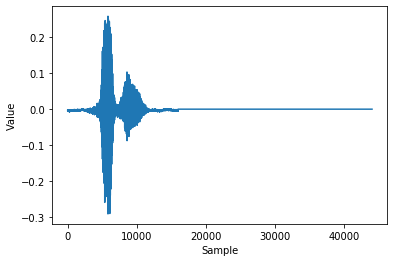

In [22]:
import matplotlib.pyplot as plt

audio = load_audio(paths[0])

plt.plot(audio.numpy().T)

plt.xlabel('Sample')

plt.ylabel('Value')

## Generate the MFCCs (Mel Frequency Cepstral Coefficients) from the audio data.

1. Apply the short-time Fourier Transform (STFT) passing in the audio signal as an argument, frame length set to 1024, and the frame step set as 256, and the FFT length as the fourth parameter.
2. Take the absolute value of the result to compute the spectrograms. \
    a. This number is given by the length along the last axis of the STFT
3. Define the upper and lower bounds of the mel weight matrix as 80 and 7600 respectively and the number of mel bins as 80.
4. Compute the mel weight matrix using linear_to_mel_weight_matrix from TensorFlow's signal package.
5. Compute the mel spectrograms via tensor construction using tensordot along axis 1 of the spectrograms with the mel weight matrix.
6. Take the log of the mel spectrograms before finally computing the MFCC's using TensorFlow's mfccs_from_log_mel_spectrograms
7. Return the MFCCs

In [27]:
def apply_mfccs(audio, sample_rate=44100, num_mfccs=13):
    stfts = tf.signal.stft(audio, frame_length=1024,
                          frame_step=256,
                          fft_length=1024)
    spectrograms = tf.abs(stfts)
    spectrogram_bins = stfts.shape[-1]
    
    lower_edge_hertz, upper_edge_hertz, mel_bins = 80.0, 7600.0, 80
    
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(mel_bins,
                                                                       spectrogram_bins,
                                                                       sample_rate,
                                                                       lower_edge_hertz,
                                                                       upper_edge_hertz)
    
    mel_spectrograms = tf.tensordot(spectrograms,
                                   linear_to_mel_weight_matrix,
                                   1)
    
    mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))
    
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)
    
    # Compute MFCCs from log_mel_spectrograms
    
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrograms)[..., :num_mfccs]
    
    return mfccs

## Apply the function above

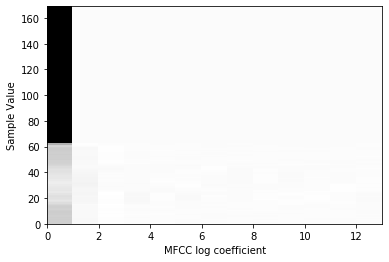

In [28]:
mfcc = apply_mfccs(audio)

plt.pcolor(mfcc.numpy()[0], cmap='Greys_r')

plt.xlabel('MFCC log coefficient')

plt.ylabel('Sample Value')

plt.savefig("Figure2.17.png", dpi=200)

## Load Autotune 

This will allow us to use all of the available threads of the CPU. \
Create a function that will take a dataset object, shuffle it, and load the audio using two previously defined functions

In [34]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

def prep_ds(ds, shuffle_buffer_size=1024, batch_size=64):
    # Randomly shuffle (file_path, label) dataset
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    # load and decode audio from file paths
    ds = ds.map(load_audio, num_parallel_calls=AUTOTUNE)
    # generate MFCCs from the audio data
    ds = ds.map(apply_mfccs)
    # Repeat dataset forever
    ds = ds.repeat()
    # Prepare batches
    ds = ds.batch(batch_size)
    # Prefetch
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    return ds

In [35]:
ds = tf.data.Dataset.from_tensor_slices(paths)

train_ds = prep_ds(ds)

## Take a single batch and print it out

In [36]:
for x in train_ds.take(1):
    print(x)

tf.Tensor(
[[[[-3.8206329e+01  6.2723041e-01  1.3823465e+00 ... -6.2591201e-01
    -8.0306756e-01  1.2597604e-01]
   [-3.9315723e+01 -5.5170771e-02  8.0528980e-01 ... -1.2248192e+00
    -1.4842975e+00 -2.8563195e-01]
   [-3.9614750e+01  3.7789813e-01  2.0292823e+00 ... -3.9295229e-01
    -1.1576303e+00  9.0283662e-02]
   ...
   [-1.7475427e+02 -7.8259567e-05  8.2965726e-06 ...  8.8049037e-06
     6.4839332e-06 -2.2959596e-06]
   [-1.7475427e+02 -7.8259567e-05  8.2965726e-06 ...  8.8049037e-06
     6.4839332e-06 -2.2959596e-06]
   [-1.7475427e+02 -7.8259567e-05  8.2965726e-06 ...  8.8049037e-06
     6.4839332e-06 -2.2959596e-06]]]


 [[[-3.1519741e+01 -4.9461231e+00 -1.1290560e+00 ... -1.7629497e+00
     7.6714176e-01 -1.9717500e-01]
   [-3.2501694e+01 -7.7198653e+00 -1.7571888e+00 ... -1.4427170e+00
     2.5064406e+00 -2.9546016e-01]
   [-3.0534563e+01 -8.0052347e+00 -1.5525652e+00 ... -4.3772566e-01
     2.5142338e+00 -1.6482546e+00]
   ...
   [-1.7475427e+02 -7.8259567e-05  8.2965726